In [1]:
# Import libraries and data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as pltticker
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import itertools as itt
import pickle as pk
import dataframe_image as dfi

with open('../data/cleaned/baseline_regression_y_pred.pickle', 'rb') as f:
    baseline_y_pred = pk.load(f)

with open('../data/cleaned/primary_discrete_interactions_y_pred.pickle', 'rb') as f:
    prim_disc_inter_y_pred = pk.load(f)

with open('../data/cleaned/baseline_regression_coeff_frame.pickle', 'rb') as f:
    baseline_df = pk.load(f)
    
with open('../data/cleaned/primary_discrete_interactions_regression_coeff_frame.pickle', 'rb') as f:
    prim_disc_inter_df = pk.load(f)

    
all_data = pd.read_parquet('../data/cleaned/cleaned_data.parquet')
full_test = pd.read_parquet('../data/cleaned/all_features_test.parquet')
y_test_norm, y_test_log, X_test = [full_test.price, full_test['log(price_plus_0)'],
                                   full_test.drop(['price', 'log(price_plus_0)'], axis = 1)]

In [2]:
# https://stackoverflow.com/questions/27164114/show-confidence-limits-and-prediction-limits-in-scatter-plot
def plot_ci_manual(t, s_err, n, x, x2, y2, ax=None):
    """Return an axes of confidence bands using a simple approach.
    
    Notes
    -----
    .. math:: \left| \: \hat{\mu}_{y|x0} - \mu_{y|x0} \: \right| \; \leq \; T_{n-2}^{.975} \; \hat{\sigma} \; \sqrt{\frac{1}{n}+\frac{(x_0-\bar{x})^2}{\sum_{i=1}^n{(x_i-\bar{x})^2}}}
    .. math:: \hat{\sigma} = \sqrt{\sum_{i=1}^n{\frac{(y_i-\hat{y})^2}{n-2}}}
    
    References
    ----------
    .. [1] M. Duarte.  "Curve fitting," Jupyter Notebook.
       http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/CurveFitting.ipynb
    
    """
    if ax is None:
        ax = plt.gca()
    
    ci = t * s_err * np.sqrt(1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
    ax.fill_between(x2, y2 + ci, y2 - ci, color="green", edgecolor=None)

    return ax

def equation(a, b):
    """Return a 1D polynomial."""
    return np.polyval(a, b)

In [3]:
def calculate_coeff_value_by_type(row, y_type):
    if y_type == 'normal':
        if row.Type == 'Normal':
            return row.Coefficient
        else:
            return row.Coefficient * np.log(1.01)
    else:
        if row.Type == 'Normal':
            return np.exp(row.Coefficient)
        else:
            return 1.01 ** row.Coefficient

In [4]:
baseline_df = baseline_df.iloc[3:]
baseline_df['conf_low'] = baseline_df.conf_int.apply(lambda x: x[0])
baseline_df['conf_high'] = baseline_df.conf_int.apply(lambda x: x[1])
baseline_df.drop('conf_int', axis = 1, inplace = True)
baseline_df = baseline_df.round(2)
baseline_df['coeff_abs'] = baseline_df.coeff.abs()
best_baseline_df_zipcodes = baseline_df.loc[(baseline_df.p_values < 0.05)
                                            & (baseline_df.param != 'const')]\
                                            .nlargest(3, 'coeff_abs').param.values.tolist()
select_params = ['waterfront', 'grade', 'sqft_living', 'sqft_lot']
params_to_show = select_params + best_baseline_df_zipcodes

In [5]:
columns_to_show = ['param', 'coeff', 'conf_low', 'conf_high']
baseline_to_show = baseline_df.loc[baseline_df.param.isin(params_to_show)][columns_to_show]
baseline_to_show.columns = ['Feature', 'Coefficient', 'Confidence Lower', 'Confidence Upper']

pd.options.display.float_format = '{:,.2f}'.format

baseline_to_show.Feature = ['Waterfront', 'Grade', 'Sqft Living',
                            'Sqft Lot', 'Zip - 98004', 'Zip - 98039', 'Zip - 98040']
baseline_to_show = baseline_to_show.groupby('Feature').first()

baseline_to_show.index = ['Grade', 'Living Area (Sq. Ft.)', 'Lot Area (Sq. Ft.)', 'Waterfront',
                         'Zip Code - Bellevue', 'Zip Code - Medina', 'Zip Code - Mercer Island']

# Save image
dfi.export(baseline_to_show, '../images/baseline_coeff.png')

In [6]:
baseline_to_show

,Coefficient,Confidence Lower,Confidence Upper
Grade,"106,165.18","97,775.46","114,554.91"
Living Area (Sq. Ft.),171.89,147.04,196.73
Lot Area (Sq. Ft.),2.84,1.97,3.71
Waterfront,"594,396.48","545,757.68","643,035.29"
Zip Code - Bellevue,"1,940,324.02","1,883,916.85","1,996,731.18"
Zip Code - Medina,"2,699,139.58","2,580,999.54","2,817,279.61"
Zip Code - Mercer Island,"1,205,093.03","1,148,273.87","1,261,912.19"


In [7]:
grouped_by_zip = all_data.groupby('zipcode').mean()
top_5_zip_by_price = grouped_by_zip.price.nlargest(5).index.tolist()
least_5_zip_by_price = grouped_by_zip.price.nsmallest(5).index.tolist()
least_5_zip_by_price.reverse()
most_influential_zip_by_price = top_5_zip_by_price + least_5_zip_by_price

In [8]:
def configure_axislabels_and_title(ax, xlabel, ylabel, title):
    # Set fonts, padding, and fontsize for axis labels and title
    ax.set_xlabel(xlabel,
                  fontfamily = 'Arial',
                  fontsize = 24,
                  labelpad = 5)

    ax.set_ylabel(ylabel,
                  fontfamily = 'Arial',
                  fontsize = 24,
                  labelpad = 10)

    ax.set_title(title,
                 fontfamily = 'Arial',
                 fontsize = 32,
                 pad = 10)
    
    return None

In [9]:
def configure_ticklabels_and_params(ax):
    # Set label sizes and tick lengths
    ax.tick_params(axis = 'both',
                   which = 'major',
                   labelsize = 16,
                   length = 8,
                   width = 1)

    # Set font for tick labels on both axes
    for tick in ax.get_xticklabels():
        tick.set_fontname("Arial")

    for tick in ax.get_yticklabels():
        tick.set_fontname("Arial")
        
    return None

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


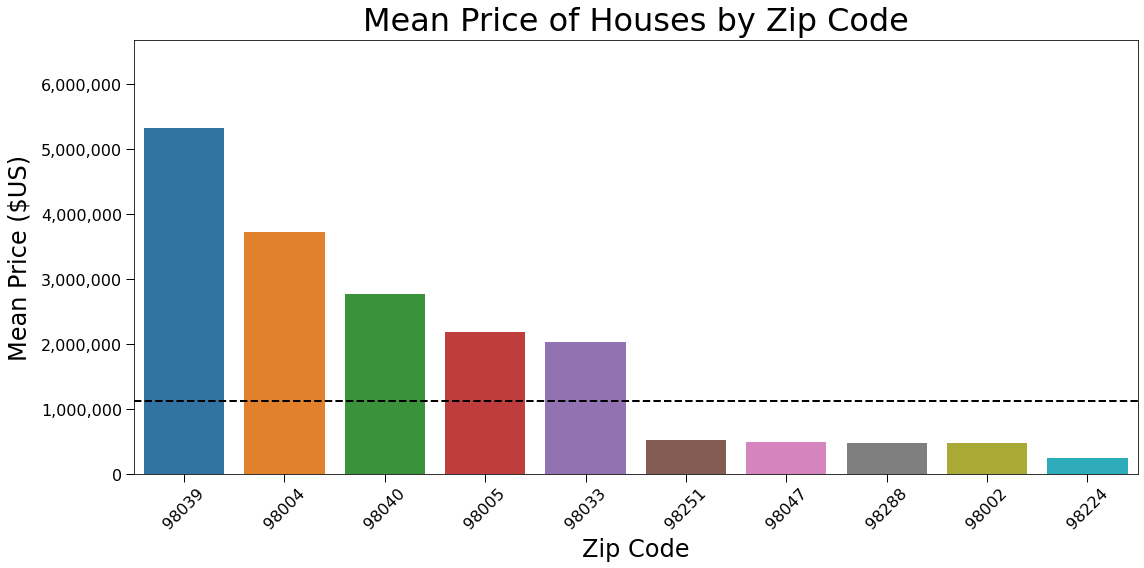

In [10]:
# Declare fig, ax objects
fig, ax = plt.subplots(figsize = (16, 8))

# Create seaborn barplot
sns.barplot(x = all_data.loc[all_data.zipcode.isin(most_influential_zip_by_price)].zipcode,
            y = all_data.price,
            order = most_influential_zip_by_price,
            errwidth = 0,
            ax = ax);

# Create horizontal line depicting mean price of all houses
ax.axhline(y = all_data.price.mean(), linestyle = '--', linewidth = 2, c = 'k')

# Set axis labels and title
configure_axislabels_and_title(ax, 'Zip Code', 'Mean Price ($US)', 'Mean Price of Houses by Zip Code')

# Configure tick labels and ticks
ax.get_yaxis().set_major_formatter(pltticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.xticks(rotation = 45)

configure_ticklabels_and_params(ax)

# Set tight layout
plt.tight_layout()

# Save image
plt.savefig('../images/mean_price_by_zipcode.png')

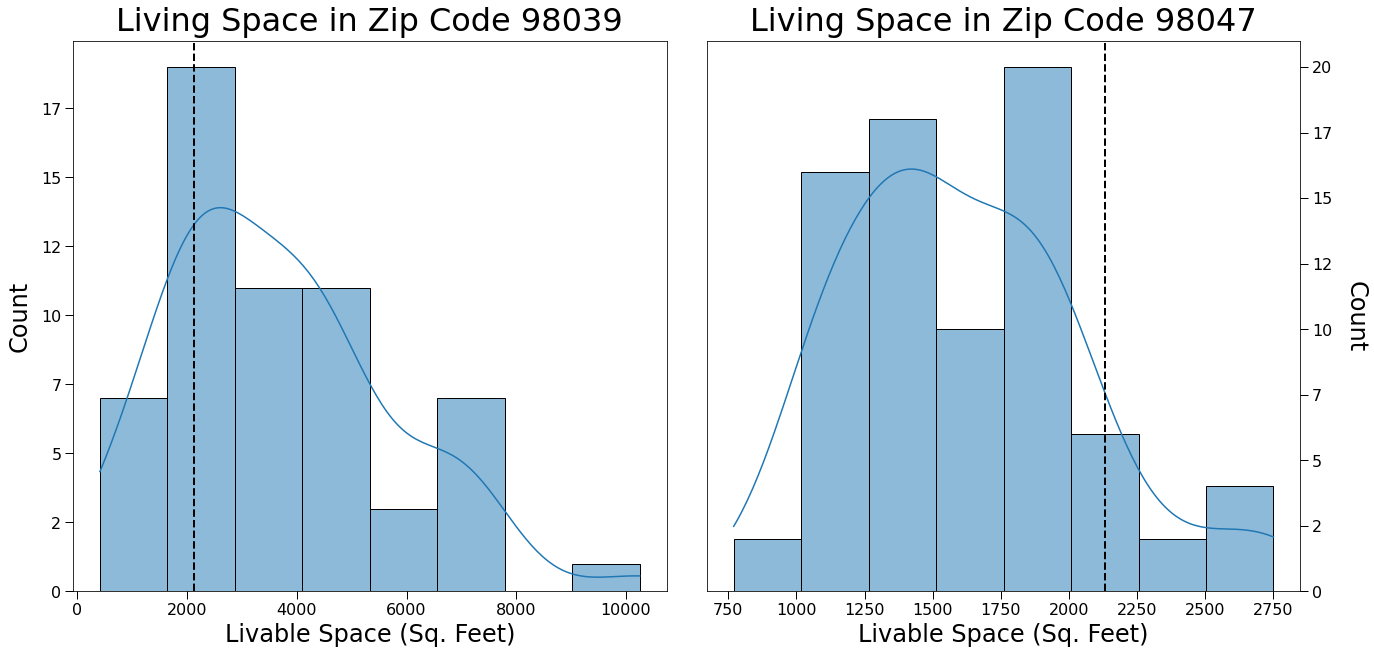

In [11]:
# Create fig, ax objects
fig, ax = plt.subplots(1, 2, figsize = (20, 10))

# Create seaborn histplots
sns.histplot(all_data.loc[all_data.zipcode == most_influential_zip_by_price[0]].sqft_living,
             kde = True,
             ax = ax[0]);

sns.histplot(all_data.loc[all_data.zipcode == most_influential_zip_by_price[6]].sqft_living,
             kde = True,
             ax = ax[1]);

# Configure axes
for axis in ax:
    axis.axvline(x = all_data.sqft_living.mean(), linestyle = '--', linewidth = 2, c = 'k')
    axis.get_yaxis().set_major_formatter(pltticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    configure_ticklabels_and_params(axis)

ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")

# Configure axis and title labels
configure_axislabels_and_title(ax[0],
                               'Livable Space (Sq. Feet)',
                               'Count',
                               'Living Space in Zip Code {}'\
                               .format(most_influential_zip_by_price[0]))

configure_axislabels_and_title(ax[1],
                               'Livable Space (Sq. Feet)',
                               'Count',
                               'Living Space in Zip Code {}'\
                               .format(most_influential_zip_by_price[6]))

# Have to set ax_1 y_label separately to rotate
ax[1].set_ylabel('Count',
                 fontfamily = 'Arial',
                 fontsize = 24,
                 labelpad = 35,
                 rotation = 270)

# Set tight layout
plt.tight_layout(pad = 4.0)

# Save image
plt.savefig('../images/sqft_living_by_zipcode.png')

In [12]:
# # Declare fig, ax objects
# fig, ax = plt.subplots(figsize = (8, 8))

# # Create seaborn scatterplot
# sns.scatterplot(x = baseline_y_pred, y = y_test_norm);

# # Draw line y = x to show where equality between prediction and actual should be
# ax.axline([0, 0], [1, 1], linestyle = '--', linewidth = 2, c = 'k');

# # Configure tick labels and ticks
# ax.get_xaxis().set_major_formatter(pltticker.FuncFormatter(lambda x, p: format(int(x/1_000_000), ',')))
# ax.get_yaxis().set_major_formatter(pltticker.FuncFormatter(lambda x, p: format(int(x/1_000_000), ',')))

# configure_ticklabels_and_params(ax)

# # Configure axis labels and title
# configure_axislabels_and_title(ax,
#                                'Predicted Price (millions of $US)',
#                                'Actual Price (millions of $US)',
#                                'Baseline Res. (R^2: 0.75)')

# # Set tight layout
# plt.tight_layout()

# # Save image
# plt.savefig('../images/baseline_residuals.png')

In [13]:
# # Declare fig, ax objects
# fig, ax = plt.subplots(figsize = (8, 8))

# # Create seaborn scatterplot
# sns.scatterplot(x = prim_disc_inter_y_pred, y = y_test_norm);

# # Draw line y = x to show where equality between prediction and actual should be
# ax.axline([0, 0], [1, 1], linestyle = '--', linewidth = 2, c = 'k');

# # Configure tick labels and ticks
# ax.get_xaxis().set_major_formatter(pltticker.FuncFormatter(lambda x, p: format(int(x/1_000_000), ',')))
# ax.get_yaxis().set_major_formatter(pltticker.FuncFormatter(lambda x, p: format(int(x/1_000_000), ',')))

# configure_ticklabels_and_params(ax)

# # Configure axis labels and title
# configure_axislabels_and_title(ax,
#                                'Predicted Price (millions of $US)',
#                                'Actual Price (millions of $US)',
#                                'Interactions Res. (R^2: 0.80)')

# # Set tight layout
# plt.tight_layout()

# # Save image
# plt.savefig('../images/prim_disc_inter_residuals.png')

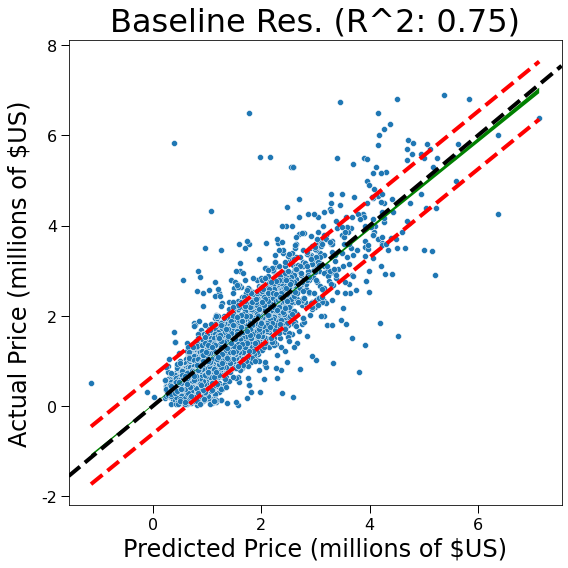

In [14]:
# Computations
x = prim_disc_inter_y_pred
y = y_test_norm.values
p, cov = np.polyfit(x, y, 1, cov=True)                     # parameters and covariance from of the fit of 1-D polynom.
y_model = equation(p, x)                                   # model using the fit parameters; NOTE: parameters here are coefficients

# Statistics
n = y_test_norm.values.size                                # number of observations
m = p.size                                                 # number of parameters
dof = n - m                                                # degrees of freedom
t = stats.t.ppf(0.975, n - m)                              # t-statistic; used for CI and PI bands

# Estimates of Error in Data/Model
resid = y - y_model                                        # residuals; diff. actual data from predicted values
chi2 = np.sum((resid / y_model)**2)                        # chi-squared; estimates error in data
chi2_red = chi2 / dof                                      # reduced chi-squared; measures goodness of fit
s_err = np.sqrt(np.sum(resid**2) / dof)                    # standard deviation of the error

# Plotting
fig, ax = plt.subplots(figsize=(8, 8))

# Data
sns.scatterplot(x = prim_disc_inter_y_pred, y = y_test_norm);

# Fit
ax.axline([0, 0], [1, 1], linestyle = '--', linewidth = 4, c = 'k');

x2 = np.linspace(np.min(x), np.max(x), 100)
y2 = equation(p, x2)

# Confidence Interval
plot_ci_manual(t, s_err, n, x, x2, y2, ax=ax)
   
# Prediction Interval
pi = t * s_err * np.sqrt(1 + 1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))   
ax.fill_between(x2, y2 + pi, y2 - pi, color="None", linestyle="--")
ax.plot(x2, y2 - pi, "--", color='r', linewidth = 4, label="95% Prediction Limits")
ax.plot(x2, y2 + pi, "--", color='r', linewidth = 4,)

# Configure tick labels and ticks
ax.get_xaxis().set_major_formatter(pltticker.FuncFormatter(lambda x, p: format(int(x/1_000_000), ',')))
ax.get_yaxis().set_major_formatter(pltticker.FuncFormatter(lambda x, p: format(int(x/1_000_000), ',')))

configure_ticklabels_and_params(ax)

# Configure axis labels and title
configure_axislabels_and_title(ax,
                               'Predicted Price (millions of $US)',
                               'Actual Price (millions of $US)',
                               'Baseline Res. (R^2: 0.75)')

# Set tight layout
plt.tight_layout()

# Save image
plt.savefig('../images/baseline_residuals.png')

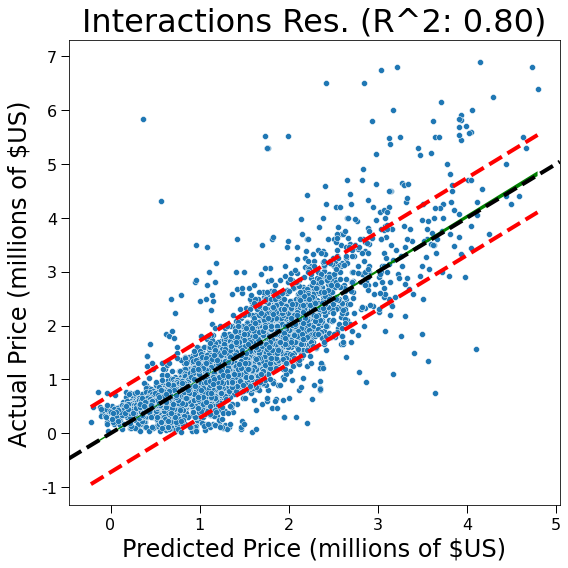

In [15]:
# Computations
x = baseline_y_pred
y = y_test_norm.values
p, cov = np.polyfit(x, y, 1, cov=True)                     # parameters and covariance from of the fit of 1-D polynom.
y_model = equation(p, x)                                   # model using the fit parameters; NOTE: parameters here are coefficients

# Statistics
n = y_test_norm.values.size                                # number of observations
m = p.size                                                 # number of parameters
dof = n - m                                                # degrees of freedom
t = stats.t.ppf(0.975, n - m)                              # t-statistic; used for CI and PI bands

# Estimates of Error in Data/Model
resid = y - y_model                                        # residuals; diff. actual data from predicted values
chi2 = np.sum((resid / y_model)**2)                        # chi-squared; estimates error in data
chi2_red = chi2 / dof                                      # reduced chi-squared; measures goodness of fit
s_err = np.sqrt(np.sum(resid**2) / dof)                    # standard deviation of the error

# Plotting
fig, ax = plt.subplots(figsize=(8, 8))

# Data
sns.scatterplot(x = baseline_y_pred, y = y_test_norm);

# Fit
ax.axline([0, 0], [1, 1], linestyle = '--', linewidth = 4, c = 'k');

x2 = np.linspace(np.min(x), np.max(x), 100)
y2 = equation(p, x2)

# Confidence Interval
plot_ci_manual(t, s_err, n, x, x2, y2, ax=ax)
   
# Prediction Interval
pi = t * s_err * np.sqrt(1 + 1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))   
ax.fill_between(x2, y2 + pi, y2 - pi, color="None", linestyle="--")
ax.plot(x2, y2 - pi, "--", color='r', linewidth = 4, label="95% Prediction Limits")
ax.plot(x2, y2 + pi, "--", color='r', linewidth = 4,)

# Configure tick labels and ticks
ax.get_xaxis().set_major_formatter(pltticker.FuncFormatter(lambda x, p: format(int(x/1_000_000), ',')))
ax.get_yaxis().set_major_formatter(pltticker.FuncFormatter(lambda x, p: format(int(x/1_000_000), ',')))

configure_ticklabels_and_params(ax)

# Configure axis labels and title
configure_axislabels_and_title(ax,
                               'Predicted Price (millions of $US)',
                               'Actual Price (millions of $US)',
                               'Interactions Res. (R^2: 0.80)')

# Set tight layout
plt.tight_layout()

# Save image
plt.savefig('../images/prim_disc_inter_residuals.png')